In [37]:
%matplotlib inline
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym

In [38]:
is_python = 'inline' in matplotlib.get_backend()
if is_python: from IPython import display

# Deep Q-Network

In [39]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3,out_features=24)
        self.fc2 = nn.Linear(in_features = 24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

# Experience class

In [40]:
Experience = namedtuple(
            'Experience',
            ('state','action','next_state','reward'))

In [41]:
e = Experience(2,3,1,4)

# Replay Memory 

In [42]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count +=1
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provid_sample(self, batch_size):
        return len(self.memory) >= batch_size

# Epsilon Greedy Strategy

In [43]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) *\
                math.exp(-1. * current_step*self.decay)

# Reinforcement Learning Agent

In [44]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step +=1
        
        if rate > random.random(): 
            action = random.randrange(self.num_actions) #explore
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) #exploit

# Environment Manager

In [45]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode = 'human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        # env.step returns the state observation
        _, reward, self.done, _ = self.env.step(action.item()) # step func will execute the action taken by agent
        return torch.tensor([reward], device = self.device )
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        '''Returns the current state of the env in the form of the pro
            image of the screen
            We will represent the single state of the env as the difference between the current screen 
            and the previous screen. This will allow the agent to take velocity of the pole into account
            one single image.
            '''
        
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        self.close()
        return  self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        
        screen = np.ascontiguousarray(screen, dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension since batched image will be passed DQN in batches
    

# Example of non-processed screen

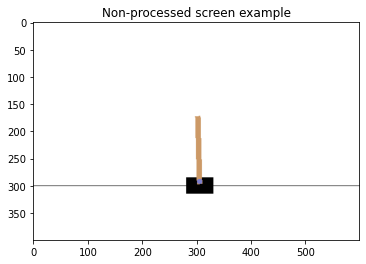

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

em = CartPoleEnvManager(device)
em.reset()

screen = em.render('rgb_array')
em.close()
plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show(block=False)
plt.close('all')

# Example of processed screen

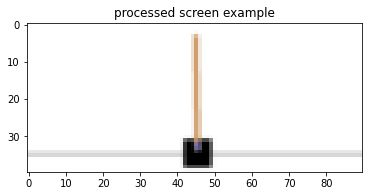

In [47]:
screen = em.get_processed_screen()
em.close()
plt.figure()
plt.imshow(screen.squeeze(0).cpu().permute(1,2,0), interpolation = 'none')
plt.title('processed screen example')
plt.show()

# Example of starting state

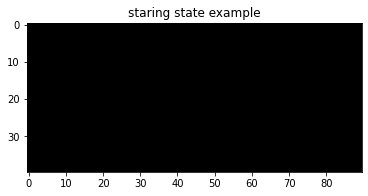

In [48]:
screen = em.get_state()
em.close()
plt.figure()
plt.imshow(screen.squeeze(0).cpu().permute(1,2,0), interpolation = 'none')
plt.title('staring state example')
plt.show()

# Example of end state

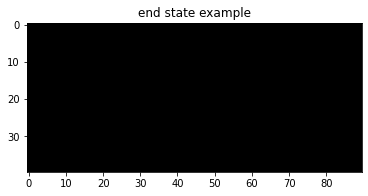

In [49]:
em.done = True
screen = em.get_state()
em.close()
plt.figure()
plt.imshow(screen.squeeze(0).cpu().permute(1,2,0), interpolation = 'none')
plt.title('end state example')
plt.show()

# Utility Function

In [50]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    moving_avg = (get_moving_average(moving_avg_period, values))
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n",\
         moving_avg_period, "episode moving avg: ",moving_avg[-1])
    if is_python: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1)\
        .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1),moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    
        

# Example plot

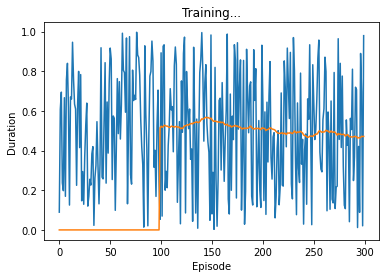

Episode 300 
 100 episode moving avg:  0.47158077


In [51]:
plot(np.random.rand(300),100)

# Main program

In [52]:
#  setting up hyperparameters
batch_size = 256
gamma =  0.999 # discount factor

# epsilon is exploration rate
eps_start = 1   # starting value of epsilon
eps_end = 0.01 # end value of epsilon
eps_decay = 0.001 # decay value of the epsilon

target_update = 10 # this is the frequency(in terms of episodes) by which we will update 
                    # the target network weights with policy network weights

memory_size = 100000 #capacity of replay memory

lr = 0.01 # learning_rate for policy nets
num_episodes = 1000 #num of episodes we want to play


# setting up essential objects for the classes we built earlier

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)


### Now creating policy network and target network by creating two instances of `DQN` class

In [53]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

In [54]:
# set the weights and biases in the target_net to be the same as those in 
# the policy_net using PyTorch's state_dict() and load_state_dict() functions. 

# target_net into eval mode, which tells PyTorch that this network is not in training mode. 
# In other words, this network will only be used for inference.

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [55]:
# optimizer equal to the Adam optimizer, which accepts our policy_net.parameters() 
#  as those for which we'll be optimizing, and our defined learning rate lr

optimizer = optim.Adam(params=policy_net.parameters(), lr = lr)

# Training loop

In [56]:
# storing our episode_durations during training in order to plot them using the plot() function we developed last time, 
#  so we create an empty list to store them in.


**Steps for main training loop**
<img src="algorithm.png" width="500" height="80">

# Tensor Processing

In [57]:
def extract_tensors(experiences):
    
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4)

### Example of Experience(\*zip(\*experience))  

In [58]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [59]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

# Q-Value Calculator

In [60]:
class QValues():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1)\
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

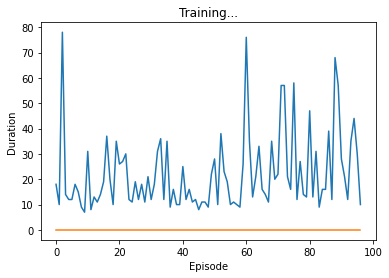

Episode 97 
 100 episode moving avg:  0.0


In [ ]:
# main training loop 
# first for loop is going to iterate over each episodes
episode_durations = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provid_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values*gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()